In [56]:
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

import utilities.utility as utility
import plotly.graph_objects as go
from pypfopt import EfficientFrontier, risk_models, expected_returns
from pypfopt import plotting

importlib.reload(utility)

<module 'utilities.utility' from '/Users/herbishtini/Documents/UNI/Master Thesis/sustainability_portfolio_optimisation/utilities/utility.py'>

In [44]:
df = pd.read_csv('../../data/df_monthly_returns_complete.csv')
df_close = pd.read_csv('../../data/df_monthly_adjacent_close.csv', index_col=0)
df_overview = pd.read_csv('../../data/df_overview.csv', index_col=0)

In [45]:
df_overview['return_rate_1y_avg'] = df_overview['return_rate_1y_avg'] - 1
df_overview['return_rate_5y_avg'] = df_overview['return_rate_5y_avg'] - 1
df_overview['return_rate_10y_avg'] = df_overview['return_rate_10y_avg'] - 1
df_overview['return_rate_25y_avg'] = df_overview['return_rate_25y_avg'] - 1

In [46]:
df_overview = df_overview.dropna()

## 1. Equities: risk-return

In [47]:
df_risk_return = df_overview.sort_values(by='market_capital_euro', ascending=False)
df_risk_return = df_risk_return[['stock_ticker_symbol', 'return_rate_25y_avg', 'return_rate_5y_avg', 'return_rate_10y_avg', 'return_rate_1y_avg', 'volatility_5y']]
# Create a scatter plot
fig = px.scatter(df_risk_return, 
                 x='volatility_5y', 
                 y='return_rate_5y_avg', 
                 # text='stock_ticker_symbol',
                 title='Risk-Return Plot',
                 labels={'volatility_5y': 'Risk (Standard Deviation)',
                         'return_rate_5y_avg': 'Investment Return Average (last 5 years)'},
                 template='plotly')


# Update layout
fig.update_layout(
    title='Efficient Frontier',
    xaxis=dict(
        title='Risk (Standard Deviation)',
        tickformat='.0%',
    ),
    yaxis=dict(
        title='Investment Return Average (last 5 years)',
        tickformat='.0%',
    )
)


# Add labels to the points
fig.update_traces(textposition='top center')

# Show the plot
fig.show()

## 2. Equities: efficient-frontier

### 2.1 Using custom-built efficient-frontier method

In [42]:
target_returns, portfolio_volatilities = utility.efficient_frontier(df_risk_return, line_point_nr=20) # circa 12 Minutes

KeyboardInterrupt: 

In [235]:
# Plot the Efficient Frontier
def plot_efficient_frontier(df):
    # Create the figure
    fig = go.Figure()

    # Add the Efficient Frontier line
    fig.add_trace(go.Scatter(
        x=portfolio_volatilities,
        y=target_returns,
        mode='lines',
        line=dict(color='red', width=3)
    ))

    # Add the individual assets as points
    fig.add_trace(go.Scatter(
        x=df_risk_return['volatility_5y'],
        y=df_risk_return['return_rate_5y_avg'],
        mode='markers',
        marker=dict(color='#636efa', size=5)
    ))

    # Update layout
    fig.update_layout(
        title='Efficient Frontier',
        xaxis=dict(
            title='Risk (Standard Deviation)',
            tickformat='.0%',
        ),
        yaxis=dict(
            title='Investment Return Average (last 5 years)',
            tickformat='.0%',
        ),
        legend=dict(x=1, y=1),
        hovermode='closest',
        template='plotly'
    )

    # Add labels to the points
    fig.update_traces(textposition='top center')

    fig.show()

plot_efficient_frontier(df_overview)

### 2.2 Using PyPortfolioOpt library

In [126]:
df_2 = pd.read_csv('../../data/df_monthly_adjacent_close.csv', parse_dates=True, index_col='Date')
df_2.index.names = ['date']

#
column_names = [column for column in df_2.columns if column.find(".T") == -1]
df_2 = df_2[column_names]

# Calculate expected annual returns and sample covariance matrix
date = pd.Timestamp.today() - pd.DateOffset(years=5)

df_2 = df_2.loc[ df_2.index >= date]

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df_2, frequency=1)

# To avoid app from crashing call 'sample_cov' in chunks
# Split DataFrame into chunks of 50 columns - 
chunk_size = 50

chunks = [df_2.iloc[:, i:i + chunk_size] for i in range(0, df_2.shape[1], chunk_size)]

# Initialize an empty DataFrame to store results
S = pd.DataFrame()

# Loop through each chunk, apply sample_cov, and concatenate the results
for index, chunk in enumerate(chunks):
    chunk_cov = risk_models.sample_cov(chunk)
    S = pd.concat([S, chunk_cov], axis=1)  # Concatenate along the column axis

50 50 59
100 50 59
150 50 59
200 50 59
250 50 59
300 50 59
350 50 59
400 50 59
450 50 59
500 50 59
550 50 59
600 50 59
650 50 59
700 50 59
750 50 59
800 50 59
850 50 59
900 50 59
950 50 59
1000 50 59
1050 50 59
1100 50 59
1150 50 59
1200 50 59
1250 50 59
1286 36 59


/Users/herbishtini/anaconda3/envs/portfolio_optimisation/lib/python3.11/site-packages/pypfopt/risk_models.py:70: UserWarning:

The covariance matrix is non positive semidefinite. Amending eigenvalues.

/Users/herbishtini/anaconda3/envs/portfolio_optimisation/lib/python3.11/site-packages/pypfopt/risk_models.py:70: UserWarning:

The covariance matrix is non positive semidefinite. Amending eigenvalues.

/Users/herbishtini/anaconda3/envs/portfolio_optimisation/lib/python3.11/site-packages/pypfopt/risk_models.py:89: UserWarning:

Could not fix matrix. Please try a different risk model.

/Users/herbishtini/anaconda3/envs/portfolio_optimisation/lib/python3.11/site-packages/pypfopt/risk_models.py:70: UserWarning:

The covariance matrix is non positive semidefinite. Amending eigenvalues.

/Users/herbishtini/anaconda3/envs/portfolio_optimisation/lib/python3.11/site-packages/pypfopt/risk_models.py:89: UserWarning:

Could not fix matrix. Please try a different risk model.

/Users/herbishtini/anaco

In [125]:
mu

RS1.L      0.004908
KE         0.000049
TEG.DE    -0.001338
LEG.DE     0.000885
SCS       -0.002150
HNI        0.007135
AVT        0.005529
ACCO      -0.005955
BRNK.DE   -0.030305
VNA.DE     0.001343
KEYS       0.005531
SGRO.L     0.002678
CBRE       0.012440
BRC        0.005685
PGRE      -0.014624
PSON.L     0.010825
BBOX.L     0.005737
REL.L      0.013174
TMV.DE    -0.014054
BHE        0.004656
PLXS       0.007913
GPE.L     -0.009637
HAS       -0.003886
CHGG      -0.050754
JLL        0.007374
LAND.L    -0.002283
OLED       0.000670
CDW        0.009109
FLEX       0.020131
REZI       0.010554
TPL        0.023470
ARW        0.007797
FN         0.021451
NOVT       0.010258
RYN        0.003075
SNX        0.010973
CMPR      -0.007330
DLAR.L    -0.007059
SHA.DE    -0.007881
TTMI       0.005165
PBI        0.009220
BYG.L      0.005932
ASGN       0.005347
COA.L      0.007753
HOUS      -0.013321
dtype: float64

ValueError: Weights is None

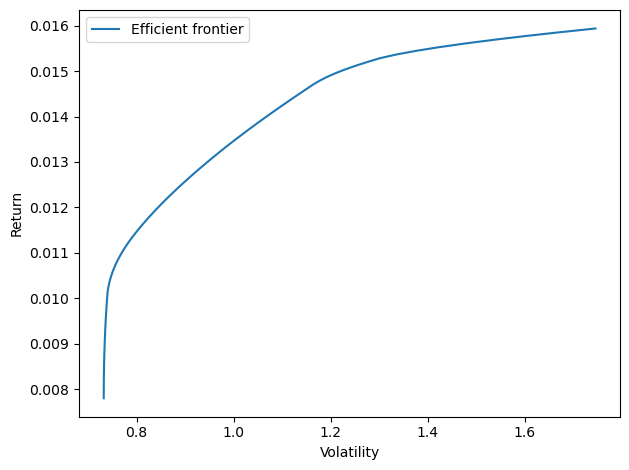

In [124]:
# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
ef.add_constraint(lambda w: w[0] >= 0.2)
ef.add_constraint(lambda w: w[2] == 0.15)
ef.add_constraint(lambda w: w[3] + w[4] <= 0.10)

# @̃TODO RESUME HERE!!!

fig, ax = plt.subplots()
ef_sharpe = ef.deepcopy()
# Get the risk-return values for the Efficient Frontier
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

#
#ef_sharpe.max_sharpe()
#ret_tangent, std_tangent, _ = ef_sharpe.portfolio_performance()
print(ret_tangent, std_tangent)
'''
ax.scatter(std_tangent, ret_tangent, 
           marker="*", 
           s=100, 
           c="r", 
           label="Max Sharpe"
           )

#
#sharpes = target_returns / portfolio_volatilities
#ax.scatter(portfolio_volatilities, target_returns, marker=".", c=sharpes, cmap="viridis_r")
'''

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()

In [123]:
ret_tangent, std_tangent, _ = ef_sharpe.portfolio_performance()
print(ret_tangent, std_tangent)

ValueError: Weights is None

In [118]:
# Plot the Efficient Frontier
def plot_pyopt_efficient_frontier(df):
    # Create the figure
    fig = go.Figure()

    # Add the Efficient Frontier line
    fig.add_trace(go.Scatter(
        x=risk_vals,
        y=return_vals,
        mode='lines',
        line=dict(color='red', width=3)
    ))

    # Add the individual assets as points
    fig.add_trace(go.Scatter(
        x=df_risk_return['volatility_5y'],
        y=df_risk_return['return_rate_5y_avg'],
        mode='markers',
        marker=dict(color='#636efa', size=5)
    ))

    # Update layout
    fig.update_layout(
        title='Efficient Frontier',
        xaxis=dict(
            title='Risk (Standard Deviation)',
            tickformat='.0%',
        ),
        yaxis=dict(
            title='Investment Return Average (last 5 years)',
            tickformat='.0%',
        ),
        legend=dict(x=1, y=1),
        hovermode='closest',
        template='plotly'
    )

    # Add labels to the points
    fig.update_traces(textposition='top center')

    fig.show()

plot_pyopt_efficient_frontier(df_overview)

NameError: name 'risk_vals' is not defined

## 3. Industry historical return rate

In [152]:
df_overview

,company_name,company_esg_score,company_esg_score_group,industry,stock_exchange,stock_ticker_symbol,market_capital,market_capital_euro,trailing_pe,beta,...,industry_Semiconductors,industry_Software & Services,industry_Technology Hardware,industry_Telecommunication Services,industry_Textiles & Apparel,industry_Traders & Distributors,industry_Transportation,industry_Transportation Infrastructure,industry_Utilities,stock_ticker_label
0,RS Group Plc,4.5,Negligible ESG Risk,Technology Hardware,LON,RS1.L,3.668791e+09,4.365861e+09,19.858974,0.863,...,0,0,1,0,0,0,0,0,0,1377
4,"Steelcase, Inc.",5.3,Negligible ESG Risk,Commercial Services,NYS,SCS,1.492860e+09,1.373431e+09,17.210526,1.314,...,0,0,0,0,0,0,0,0,0,1406
6,"Avnet, Inc.",5.6,Negligible ESG Risk,Technology Hardware,NAS,AVT,4.396814e+09,4.045069e+09,9.189688,1.171,...,0,0,1,0,0,0,0,0,0,478
10,"Dai Nippon Printing Co., Ltd.",6.1,Negligible ESG Risk,Commercial Services,TKS,7912.T,1.222490e+12,1.454763e+12,10.515173,0.450,...,0,0,0,0,0,0,0,0,0,253
11,"Keysight Technologies, Inc.",6.2,Negligible ESG Risk,Technology Hardware,NYS,KEYS,2.530604e+10,2.328156e+10,28.096340,0.974,...,0,0,1,0,0,0,0,0,0,1024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,"Halozyme Therapeutics, Inc.",19.9,Low ESG Risk,Pharmaceuticals,NAS,HALO,7.504405e+09,7.504405e+09,22.961240,1.278,...,0,0,0,0,0,0,0,0,0,884
1655,Matthews International Corp.,20.0,Low ESG Risk,Commercial Services,NAS,MATW,7.028269e+08,7.028269e+08,27.345238,1.061,...,0,0,0,0,0,0,0,0,0,1099
1656,Arclands Corp.,20.0,Low ESG Risk,Retailing,TKS,9842.T,1.069842e+11,1.069842e+11,14.463819,0.241,...,0,0,0,0,0,0,0,0,0,365
1660,"Japan Material Co., Ltd.",20.0,Low ESG Risk,Semiconductors,TKS,6055.T,1.704423e+11,1.704423e+11,27.933996,0.585,...,1,0,0,0,0,0,0,0,0,141


In [153]:
# Convert 'date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Melt the returns dataframe to long format
df_long_returns = df.melt(id_vars=['Date'], var_name='stock_ticker_symbol', value_name='return_rate_5y')

# Merge the returns and industries dataframes
df_merged = pd.merge(df_long_returns, df_overview, on='stock_ticker_symbol')

# Resample to monthly and calculate mean return for each ticker
df_merged.set_index('Date', inplace=True)

df_i_share_ratio = df_merged[['industry', 'return_rate_5y', 'volatility_5y']].fillna(1).groupby(['industry', df_merged.index]).agg({'return_rate_5y': 'mean', 'volatility_5y': 'mean'})
#df_i_share_ratio

Creating separate columns from indices

In [154]:
df_i_share_ratio = df_i_share_ratio.reset_index(level=0)
df_i_share_ratio = df_i_share_ratio.reset_index(level=0)

In [155]:
# Create line plot
fig = px.line(df_i_share_ratio, 
              x='Date', 
              y='return_rate_5y',
              color='industry', 
              title='Industry historical returns',
              labels={'Date': 'Date', 'return_rate_5y': 'Return Rate'})

# Show the plot
fig.show()

## 4. Industry correlation

In [156]:
# Pivot the DataFrame so that each industry is a column and the rows represent dates
df_industry_heatmap = df_i_share_ratio[['Date', 'industry', 'return_rate_5y']].pivot(index='Date', columns='industry', values='return_rate_5y')

# Ensure the columns are in a consistent order (optional)
df_industry_heatmap = df_industry_heatmap.sort_index(axis=1)

# Calculate the correlation matrix
correlation_matrix = df_industry_heatmap.corr()

In [157]:
# Create the heatmap
fig = px.imshow(correlation_matrix,
                # labels=dict(x="Industry", y="Industry", color="Correlation"),
                x=correlation_matrix.columns,
                y=correlation_matrix.index,
                color_continuous_scale="RdBu",
                title="Industry Correlation Heatmap")

fig.layout.height = 1000
fig.layout.width = 1250

# Show the figure
fig.show()